# Koszty ubezpieczenia medycznego

## Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
import scikitplot as skplt
from matplotlib.pylab import rcParams

## Analiza bazy

### Wczytanie danych

In [2]:
insurance_df = pd.read_csv('insurance.csv')

### Wyświetlenie danych

In [3]:
insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### Sprawdzenie typów danych i wartości nullowych

In [4]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Baza nie zawiera wartości nullowych.

### Przekształcenie wartości kategorycznych

In [5]:
le = LabelEncoder()
insurance_df['sex'] = le.fit_transform(insurance_df['sex'])
insurance_df['smoker'] = le.fit_transform(insurance_df['smoker'])
insurance_df['region'] = le.fit_transform(insurance_df['region'])

### Sprawdzenie statystyk

In [6]:
insurance_df.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.104885,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


### Analiza korelacji

In [7]:
correlation = insurance_df.corr()
correlation['charges'].sort_values(ascending=False)

charges     1.000000
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
sex         0.057292
region     -0.006208
Name: charges, dtype: float64

Wyświetlenie korelacji w formie graficznej

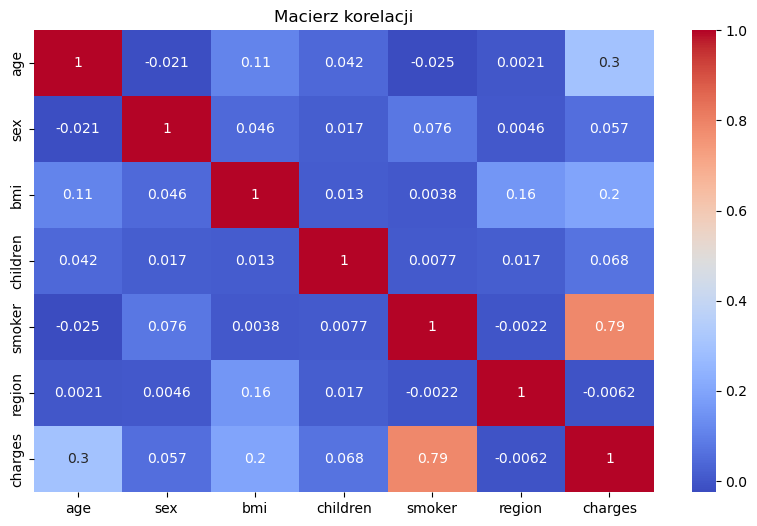

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Macierz korelacji")
plt.show()

### Analiza wieku

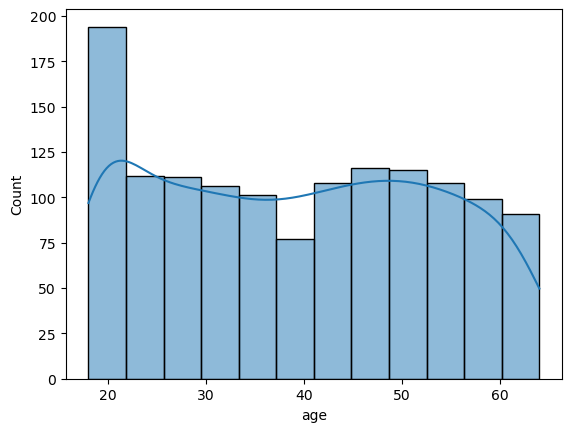

In [9]:
sns.histplot(insurance_df['age'], kde=True)
plt.show()

Grupa badawcza to populacja w wieku produkcyjnym (18 - 64 lata)

### Analiza zależności między płcią, regionem, paleniem, BMI, posiadaniem dzieci a kosztami ubezpieczenia

In [10]:
# Utworzenie kopii df
analysis_df = insurance_df.copy()

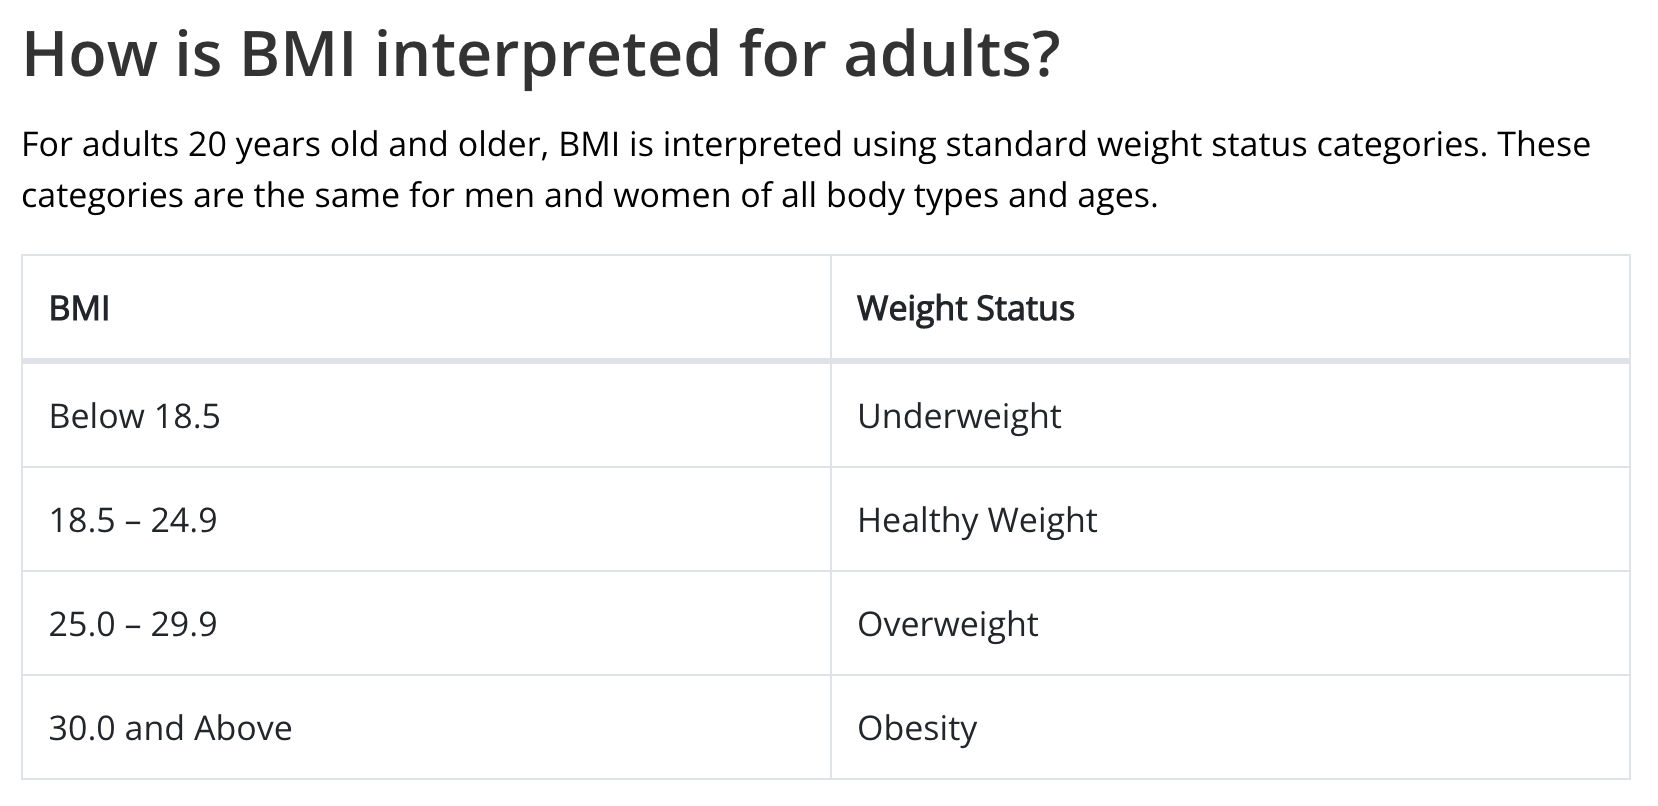

Baza zwiera populację w wieku produkcyjnym, dlatego powyzszy podział został przyjęty dla wszystkich badanych

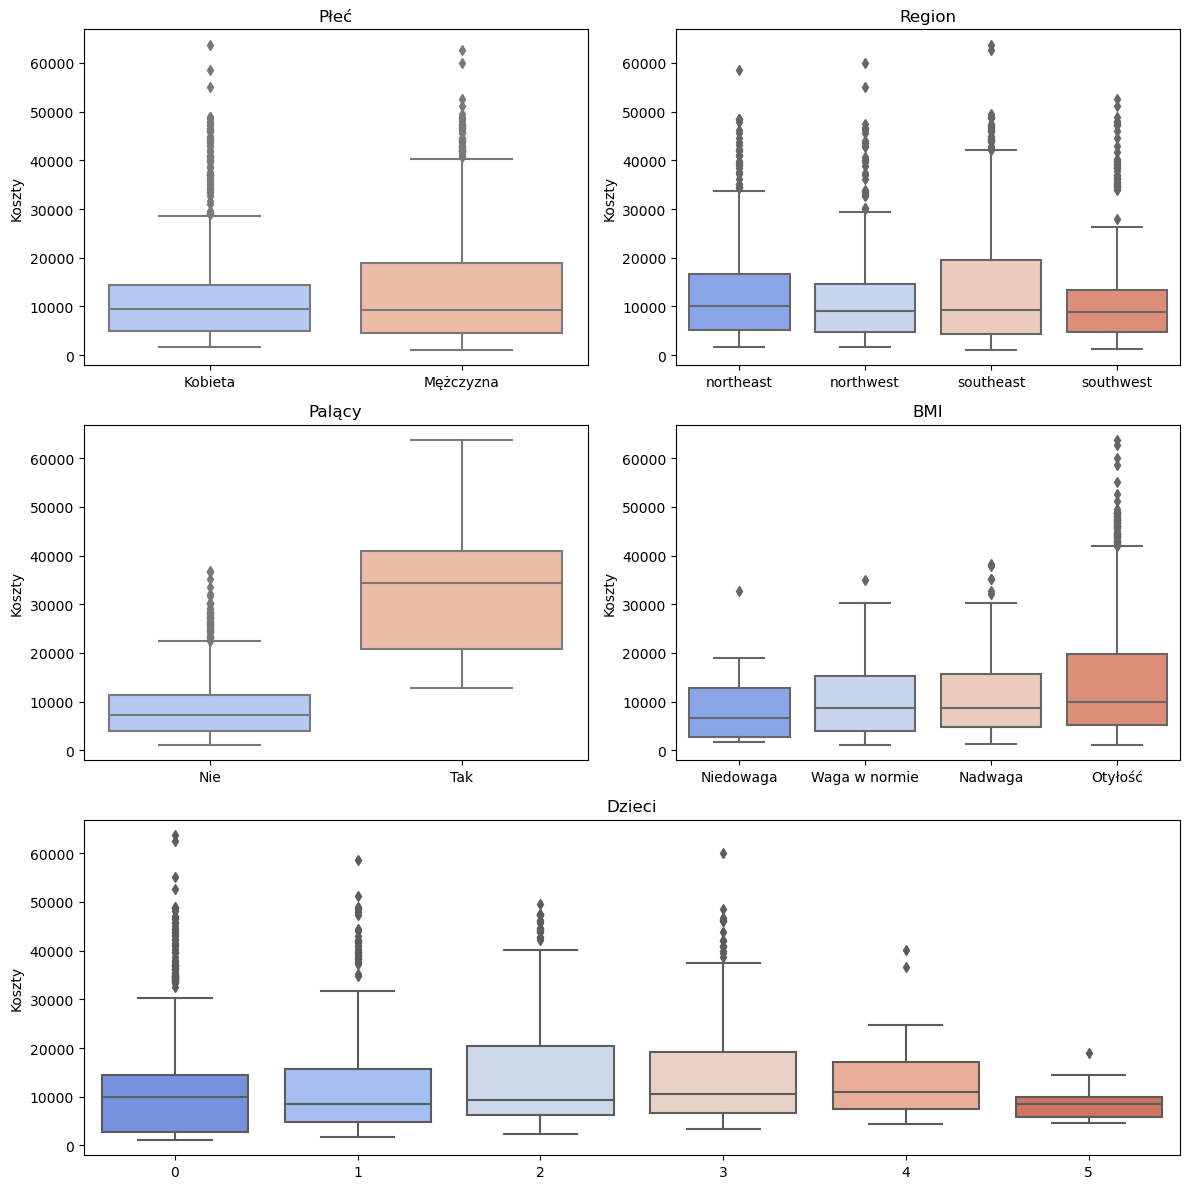

In [11]:
analysis_df['bmi_category'] = pd.cut(analysis_df['bmi'], bins=[0, 18.5, 24.9, 29.9, float('inf')], labels=['Niedowaga', 'Waga w normie', 'Nadwaga', 'Otyłość'])

plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
sns.boxplot(x='sex', y='charges', data=analysis_df, palette='coolwarm')
plt.title("Płeć")
plt.xlabel("")
plt.ylabel("Koszty")
plt.xticks([0, 1], ['Kobieta', 'Mężczyzna'])

plt.subplot(3, 2, 2)
sns.boxplot(x='region', y='charges', data=analysis_df, palette='coolwarm')
plt.title("Region")
plt.xlabel("")
plt.ylabel("Koszty")
plt.xticks([0, 1, 2, 3], ['northeast', 'northwest', 'southeast', 'southwest'])

plt.subplot(3, 2, 3)
sns.boxplot(x='smoker', y='charges', data=analysis_df, palette='coolwarm')
plt.title("Palący")
plt.xlabel("")
plt.ylabel("Koszty")
plt.xticks([0, 1], ['Nie', 'Tak'])

plt.subplot(3, 2, 4)
sns.boxplot(x='bmi_category', y='charges', data=analysis_df, palette='coolwarm')
plt.title("BMI")
plt.xlabel("")
plt.ylabel("Koszty")

plt.subplot2grid((3, 2), (2, 0), colspan=2)
sns.boxplot(x='children', y='charges', data=analysis_df, palette='coolwarm')
plt.title("Dzieci")
plt.xlabel("")
plt.ylabel("Koszty")

plt.tight_layout()
plt.show()

### Pairplot z podziałem na palących i niepalących

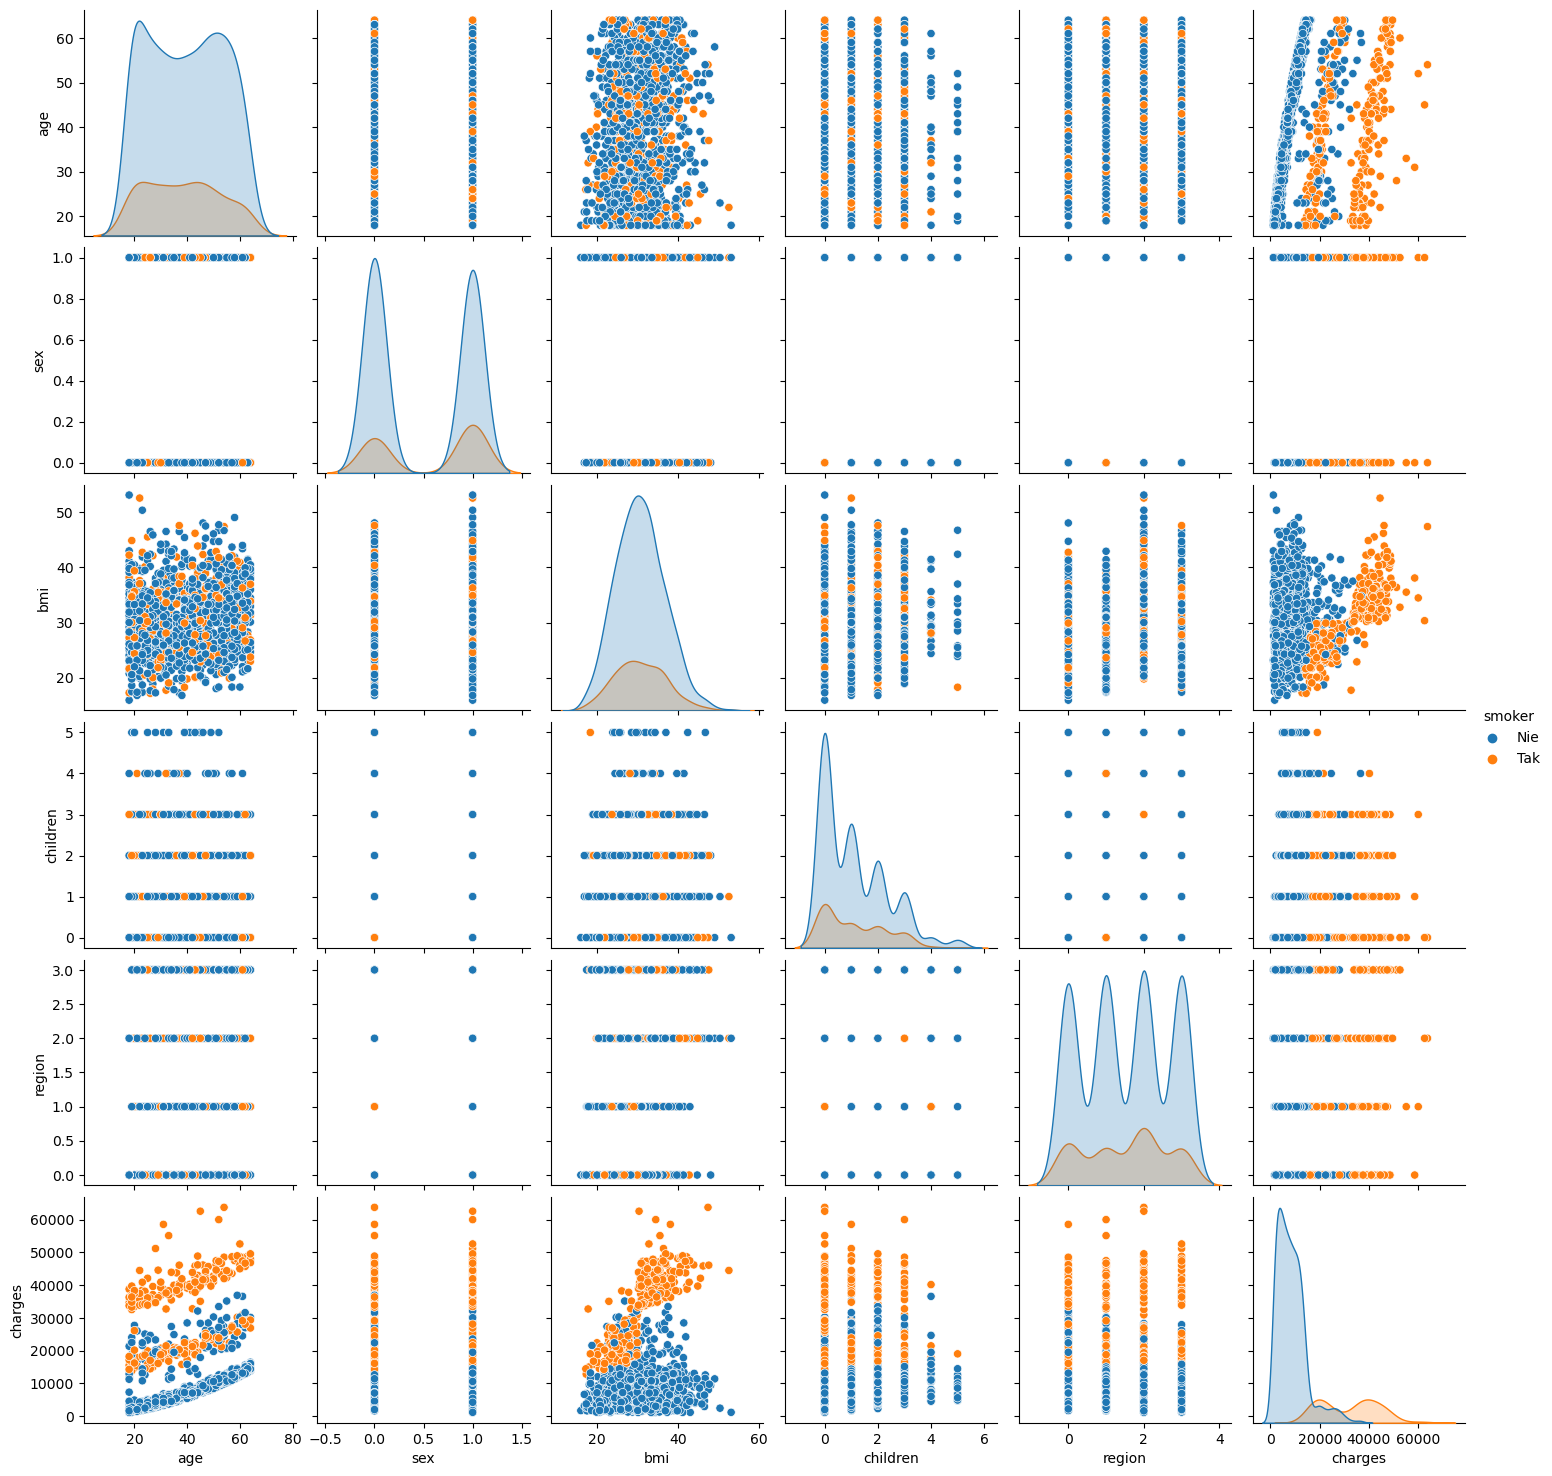

In [12]:
pplot = sns.pairplot(analysis_df, hue="smoker")
legend_labels = ['Nie', 'Tak']
for t, l in zip(pplot._legend.texts, legend_labels):
    t.set_text(l)
plt.show()

### Porównanie korelacji z podziałem na palących i niepalących

In [13]:
insurance_df_s = analysis_df[(analysis_df['smoker'] == 1)]
insurance_df_ns = analysis_df[(analysis_df['smoker'] == 0)]

corr_matrix_s = insurance_df_s.drop(columns=['smoker', 'bmi_category']).corr().sort_values('charges', ascending=False)
corr_matrix_ns = insurance_df_ns.drop(columns=['smoker', 'bmi_category']).corr().sort_values('charges', ascending=False)

Korelacje dla palących

In [14]:
corr_matrix_s['charges'].sort_values(ascending=False)

charges     1.000000
bmi         0.806481
age         0.368224
region      0.128983
sex         0.101226
children    0.035945
Name: charges, dtype: float64

Korelacje dla niepalących

In [15]:
corr_matrix_ns['charges'].sort_values(ascending=False)

charges     1.000000
age         0.627947
children    0.138929
bmi         0.084037
sex        -0.056320
region     -0.073316
Name: charges, dtype: float64

Porównanie graficzne

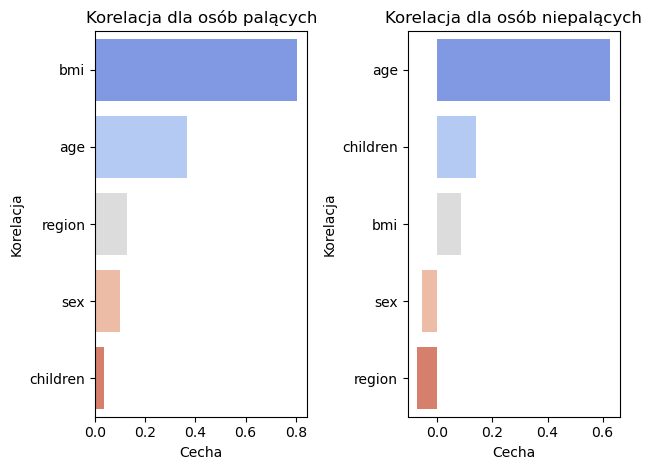

In [16]:
plt.subplot(1, 2, 1)
sns.barplot(x=corr_matrix_s['charges'].drop('charges').values, y=corr_matrix_s['charges'].drop('charges').index, palette='coolwarm')
plt.title('Korelacja dla osób palących')
plt.xlabel('Cecha')
plt.ylabel('Korelacja')

plt.subplot(1, 2, 2)
sns.barplot(x=corr_matrix_ns['charges'].drop('charges').values, y=corr_matrix_ns['charges'].drop('charges').index, palette='coolwarm')
plt.title('Korelacja dla osób niepalących')
plt.xlabel('Cecha')
plt.ylabel('Korelacja')

plt.tight_layout()
plt.show()

Wśród osób niepalących mozemy zaobserwowac ujemną korelację, dlatego na potrzeby wizualizacji i oszacowania istotności cech przekształacmy wartości na dodatnie.

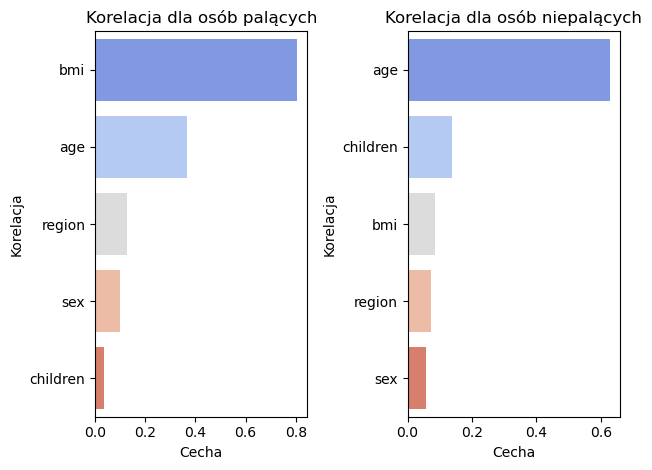

In [17]:
corr_matrix_ns_abs = abs(corr_matrix_ns).sort_values('charges', ascending=False)

plt.subplot(1, 2, 1)
sns.barplot(x=corr_matrix_s['charges'].drop('charges').values, y=corr_matrix_s['charges'].drop('charges').index, palette='coolwarm')
plt.title('Korelacja dla osób palących')
plt.xlabel('Cecha')
plt.ylabel('Korelacja')

plt.subplot(1, 2, 2)
sns.barplot(x=corr_matrix_ns_abs['charges'].drop('charges').values, y=corr_matrix_ns_abs['charges'].drop('charges').index, palette='coolwarm')
plt.title('Korelacja dla osób niepalących')
plt.xlabel('Cecha')
plt.ylabel('Korelacja')

plt.tight_layout()
plt.show()

## ML - Modele predyckcji ceny ubezpieczenia

Tworzymy funkcję uruchamiającą modele

In [18]:
def run_model(model, X, y, cross_val):
    model_name = type(model).__name__

    rmse = -cross_val_score(model, X, y, cv=cross_val, scoring='neg_root_mean_squared_error')
    r2 = cross_val_score(model, X, y, cv=cross_val, scoring='r2')
    results = {
        'Model': model_name,
        'RMSE': round(np.mean(rmse), 4),
        'R2': round(np.mean(r2) * 100, 2)
    }

    return results

Podział na zbiór cech (X) i zmienną zależną (y)

In [19]:
X = insurance_df.drop(columns=['charges'], axis=1)
y = insurance_df['charges']

Podział na zbiór treningowy i testowy

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# walidacja
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Wybór modeli

In [22]:
lr = LinearRegression()
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
enet = ElasticNet(random_state=42)
tree = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

models = [lr, lasso, ridge, enet, tree, rf, xg_reg]
results_dict = {}

Uruchomienie modeli i sprawdzenie wyników

In [23]:
for model in models:
    results = run_model(model, X_train, y_train, kf)
    results_dict[model] = results

In [24]:
results_df = pd.DataFrame(results_dict.values())
results_df.columns = ['Model', 'RMSE', 'R2']
results_df

,Model,RMSE,R2
0,LinearRegression,6112.6762,73.98
1,Lasso,6112.5643,73.98
2,Ridge,6112.8442,73.98
3,ElasticNet,9451.2912,37.85
4,DecisionTreeRegressor,6560.5875,69.96
5,RandomForestRegressor,4916.0771,83.18
6,XGBRegressor,5369.6282,79.95


Sprawdźmy teraz modele po uzyciu StandardScaler oraz PolynomialFeatures

In [25]:
X = insurance_df.drop(columns=['charges'], axis=1)
y = insurance_df['charges']

num_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2)),
    ('std_scaler', StandardScaler())
])

num_attribs = ['age', 'bmi', 'sex', 'smoker', 'region', 'children']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs)
])

X_pp = full_pipeline.fit_transform(X)

X_train_pp, X_test_pp, y_train_pp, y_test_pp = train_test_split(X_pp, y, test_size=0.2, random_state=42)

In [26]:
results_dict_pp = {}

In [27]:
for model in models:
    results = run_model(model, X_train_pp, y_train_pp, kf)
    results_dict[model] = results

/Users/jakubsutowski/anaconda3/envs/envpy/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e+08, tolerance: 1.202e+07
  model = cd_fast.enet_coordinate_descent(
/Users/jakubsutowski/anaconda3/envs/envpy/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.866e+08, tolerance: 1.233e+07
  model = cd_fast.enet_coordinate_descent(
/Users/jakubsutowski/anaconda3/envs/envpy/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

In [28]:
results_pp_df = pd.DataFrame(results_dict.values())
results_pp_df.columns = ['Model', 'RMSE', 'R2']
results_pp_df

,Model,RMSE,R2
0,LinearRegression,4869.1251,83.43
1,Lasso,4862.0932,83.48
2,Ridge,4861.3720,83.49
3,ElasticNet,5831.2941,76.31
4,DecisionTreeRegressor,6557.8363,70.03
5,RandomForestRegressor,4890.7077,83.34
6,XGBRegressor,5243.6636,80.83


Dostrójmy hiperparametry

In [29]:
results_grid_dict = {}

In [30]:
param_grid = {
    'fit_intercept': [True, False]
}

lr_grid = GridSearchCV(lr, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
lr_grid.fit(X_train_pp, y_train_pp)

results_grid = run_model(lr_grid.best_estimator_, X_train_pp, y_train_pp, kf)
results_grid_dict[lr_grid.best_estimator_] = results_grid

In [31]:
param_grid = {
    'fit_intercept': [True, False]
}

lasso_grid = GridSearchCV(lasso, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
lasso_grid.fit(X_train_pp, y_train_pp)

results_grid = run_model(lasso_grid.best_estimator_, X_train_pp, y_train_pp, kf)
results_grid_dict[lasso_grid.best_estimator_] = results_grid

/Users/jakubsutowski/anaconda3/envs/envpy/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.120e+09, tolerance: 1.242e+07
  model = cd_fast.enet_coordinate_descent(
/Users/jakubsutowski/anaconda3/envs/envpy/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e+08, tolerance: 1.194e+07
  model = cd_fast.enet_coordinate_descent(
/Users/jakubsutowski/anaconda3/envs/envpy/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

In [32]:
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False]
}

ridge_grid = GridSearchCV(ridge, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
ridge_grid.fit(X_train_pp, y_train_pp)

results_grid = run_model(ridge_grid.best_estimator_, X_train_pp, y_train_pp, kf)
results_grid_dict[ridge_grid.best_estimator_] = results_grid

In [33]:
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.2, 0.5, 0.8],
    'fit_intercept': [True, False],
}

enet_grid = GridSearchCV(enet, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
enet_grid.fit(X_train_pp, y_train_pp)

results_grid = run_model(enet_grid.best_estimator_, X_train_pp, y_train_pp, kf)
results_grid_dict[enet_grid.best_estimator_] = results_grid

In [34]:
param_grid = {
              "min_samples_split": [2, 5, 10, 20, 40],
              "max_depth": range(1,11),
              "min_samples_leaf": range(30,45),
              "max_leaf_nodes": range(15,23),
}

tree_grid = GridSearchCV(tree, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
tree_grid.fit(X_train_pp, y_train_pp)

results_grid = run_model(tree_grid.best_estimator_, X_train_pp, y_train_pp, kf)
results_grid_dict[tree_grid.best_estimator_] = results_grid

In [35]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": range(1, 10, 1),
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4, 6]
}

rf = RandomForestRegressor(random_state=42)
rf_grid = grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)

results_grid = run_model(rf_grid.best_estimator_, X_train, y_train, kf)
results_grid_dict[rf_grid.best_estimator_] = results_grid

In [36]:
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg_grid = GridSearchCV(xgb_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
xgb_reg_grid.fit(X_train, y_train)

results_grid = run_model(xgb_reg_grid.best_estimator_, X_train, y_train, kf)
results_grid_dict[xgb_reg_grid.best_estimator_] = results_grid

In [37]:
results_grid_df = pd.DataFrame(results_grid_dict.values())
results_grid_df.columns = ['Model', 'RMSE', 'R2']
results_grid_df

,Model,RMSE,R2
0,LinearRegression,4869.1251,83.43
1,Lasso,4862.0932,83.48
2,Ridge,4863.1756,83.47
3,ElasticNet,5038.6842,82.27
4,DecisionTreeRegressor,4769.8300,84.11
5,RandomForestRegressor,4493.7387,85.88
6,XGBRegressor,4514.6674,85.74


### Zestawienie wyników

In [38]:
results_df.sort_values('R2', ascending=False)

,Model,RMSE,R2
5,RandomForestRegressor,4916.0771,83.18
6,XGBRegressor,5369.6282,79.95
0,LinearRegression,6112.6762,73.98
1,Lasso,6112.5643,73.98
2,Ridge,6112.8442,73.98
4,DecisionTreeRegressor,6560.5875,69.96
3,ElasticNet,9451.2912,37.85


In [39]:
results_pp_df.sort_values('R2', ascending=False)

,Model,RMSE,R2
2,Ridge,4861.3720,83.49
1,Lasso,4862.0932,83.48
0,LinearRegression,4869.1251,83.43
5,RandomForestRegressor,4890.7077,83.34
6,XGBRegressor,5243.6636,80.83
3,ElasticNet,5831.2941,76.31
4,DecisionTreeRegressor,6557.8363,70.03


In [40]:
results_grid_df.sort_values('R2', ascending=False)

,Model,RMSE,R2
5,RandomForestRegressor,4493.7387,85.88
6,XGBRegressor,4514.6674,85.74
4,DecisionTreeRegressor,4769.8300,84.11
1,Lasso,4862.0932,83.48
2,Ridge,4863.1756,83.47
0,LinearRegression,4869.1251,83.43
3,ElasticNet,5038.6842,82.27


Wykresy porównujący wyniki

Najpierw porówujemy wyniki defaultowych modeli

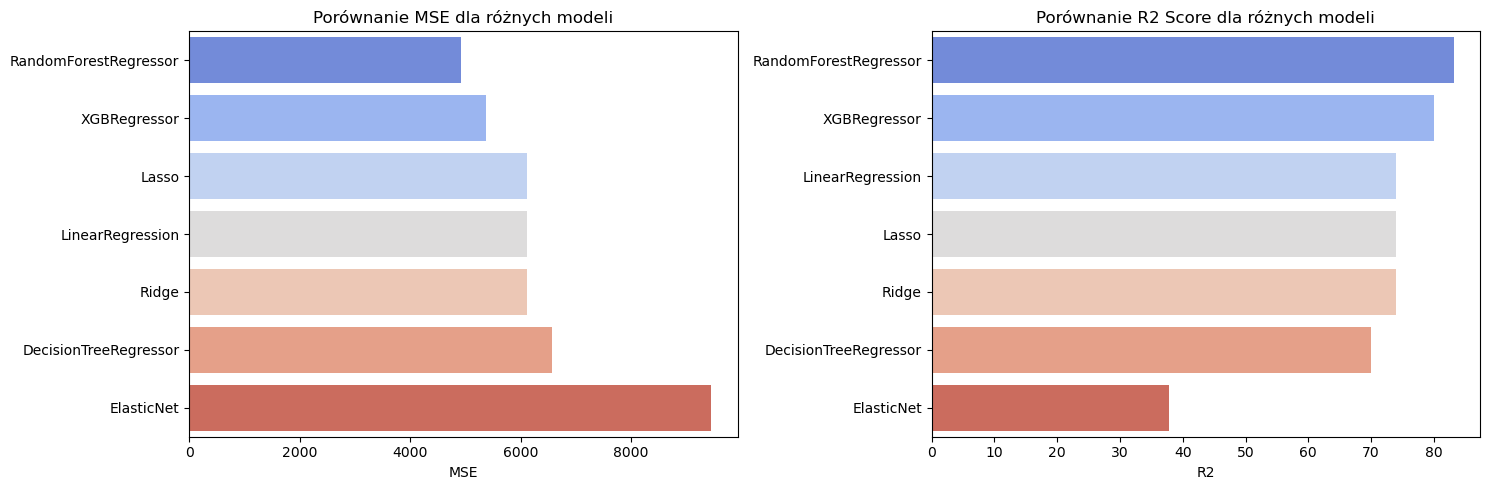

In [41]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.barplot(y='Model', x='RMSE', data=results_df.sort_values('RMSE'), palette='coolwarm')
plt.title('Porównanie MSE dla różnych modeli')
plt.ylabel('')
plt.xlabel('MSE')
plt.ticklabel_format(style='plain', axis='x')

plt.subplot(1, 2, 2)
sns.barplot(y='Model', x='R2', data=results_df.sort_values('R2', ascending=False), palette='coolwarm')
plt.title('Porównanie R2 Score dla różnych modeli')
plt.ylabel('')
plt.xlabel('R2')

plt.tight_layout()
plt.show()

Teraz modele po przeskalowaniu oraz zastosowaniu wielomianu

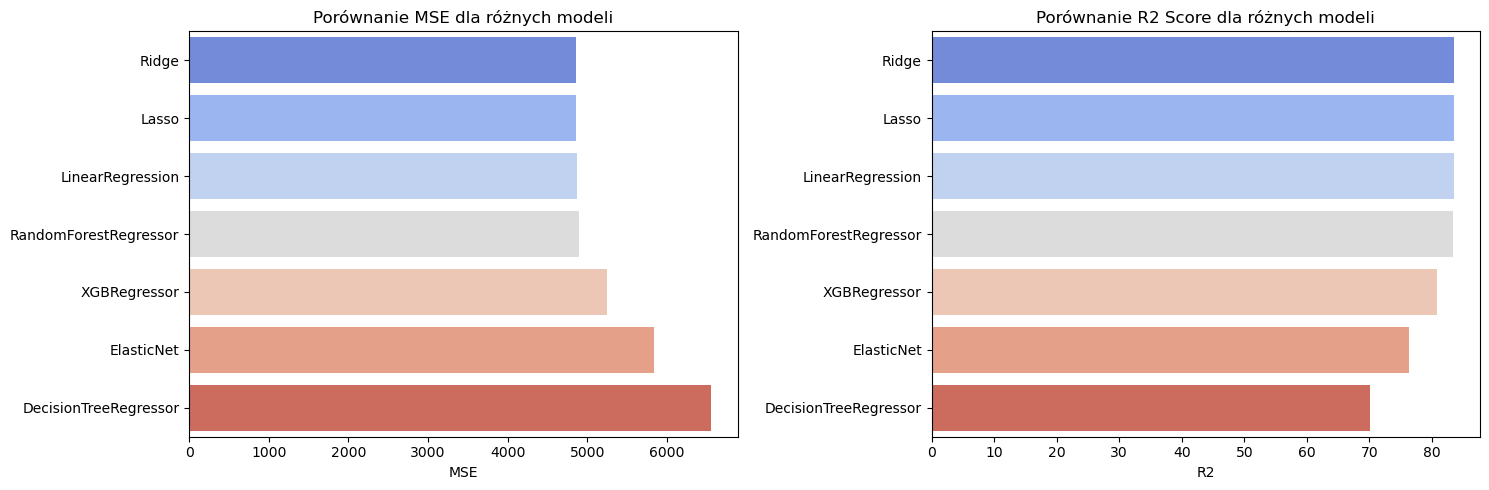

In [42]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.barplot(y='Model', x='RMSE', data=results_pp_df.sort_values('RMSE'), palette='coolwarm')
plt.title('Porównanie MSE dla różnych modeli')
plt.ylabel('')
plt.xlabel('MSE')
plt.ticklabel_format(style='plain', axis='x')

plt.subplot(1, 2, 2)
sns.barplot(y='Model', x='R2', data=results_pp_df.sort_values('R2', ascending=False), palette='coolwarm')
plt.title('Porównanie R2 Score dla różnych modeli')
plt.ylabel('')
plt.xlabel('R2')

plt.tight_layout()
plt.show()

Na koniec modele po dostrajaniu

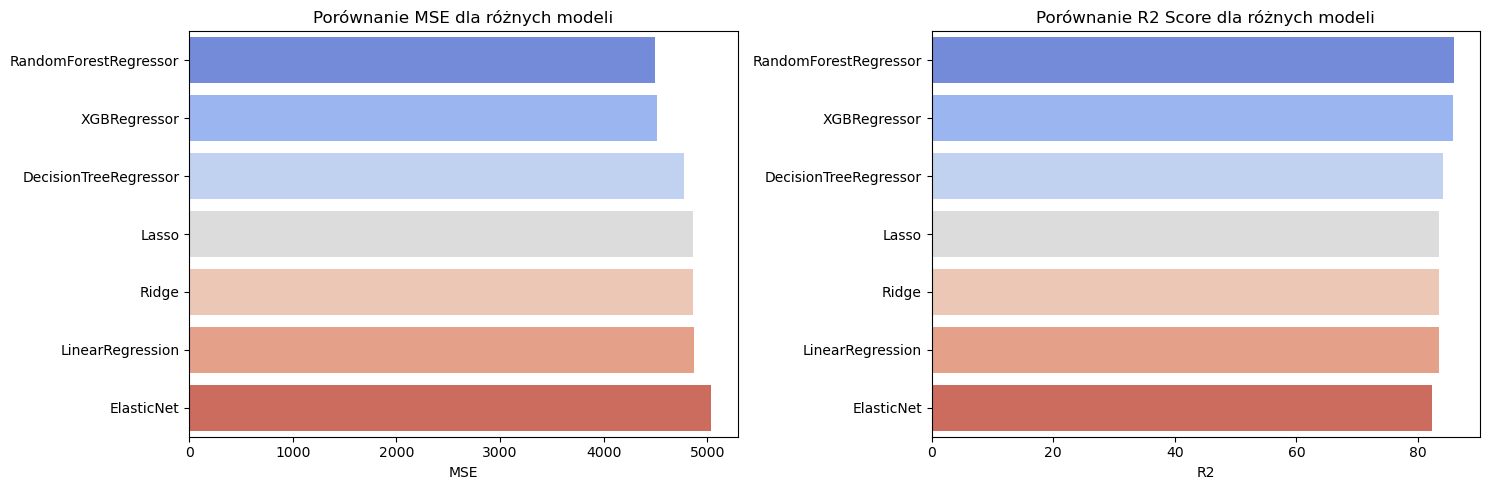

In [43]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.barplot(y='Model', x='RMSE', data=results_grid_df.sort_values('RMSE'), palette='coolwarm')
plt.title('Porównanie MSE dla różnych modeli')
plt.ylabel('')
plt.xlabel('MSE')
plt.ticklabel_format(style='plain', axis='x')

plt.subplot(1, 2, 2)
sns.barplot(y='Model', x='R2', data=results_grid_df.sort_values('R2', ascending=False), palette='coolwarm')
plt.title('Porównanie R2 Score dla różnych modeli')
plt.ylabel('')
plt.xlabel('R2')

plt.tight_layout()
plt.show()

Przyjrzyjmy się dwóm najlepszym modelem - RandomForest orax XGBoost

Najpierw zobaczymy jak wgląda proces dezycyjny RF

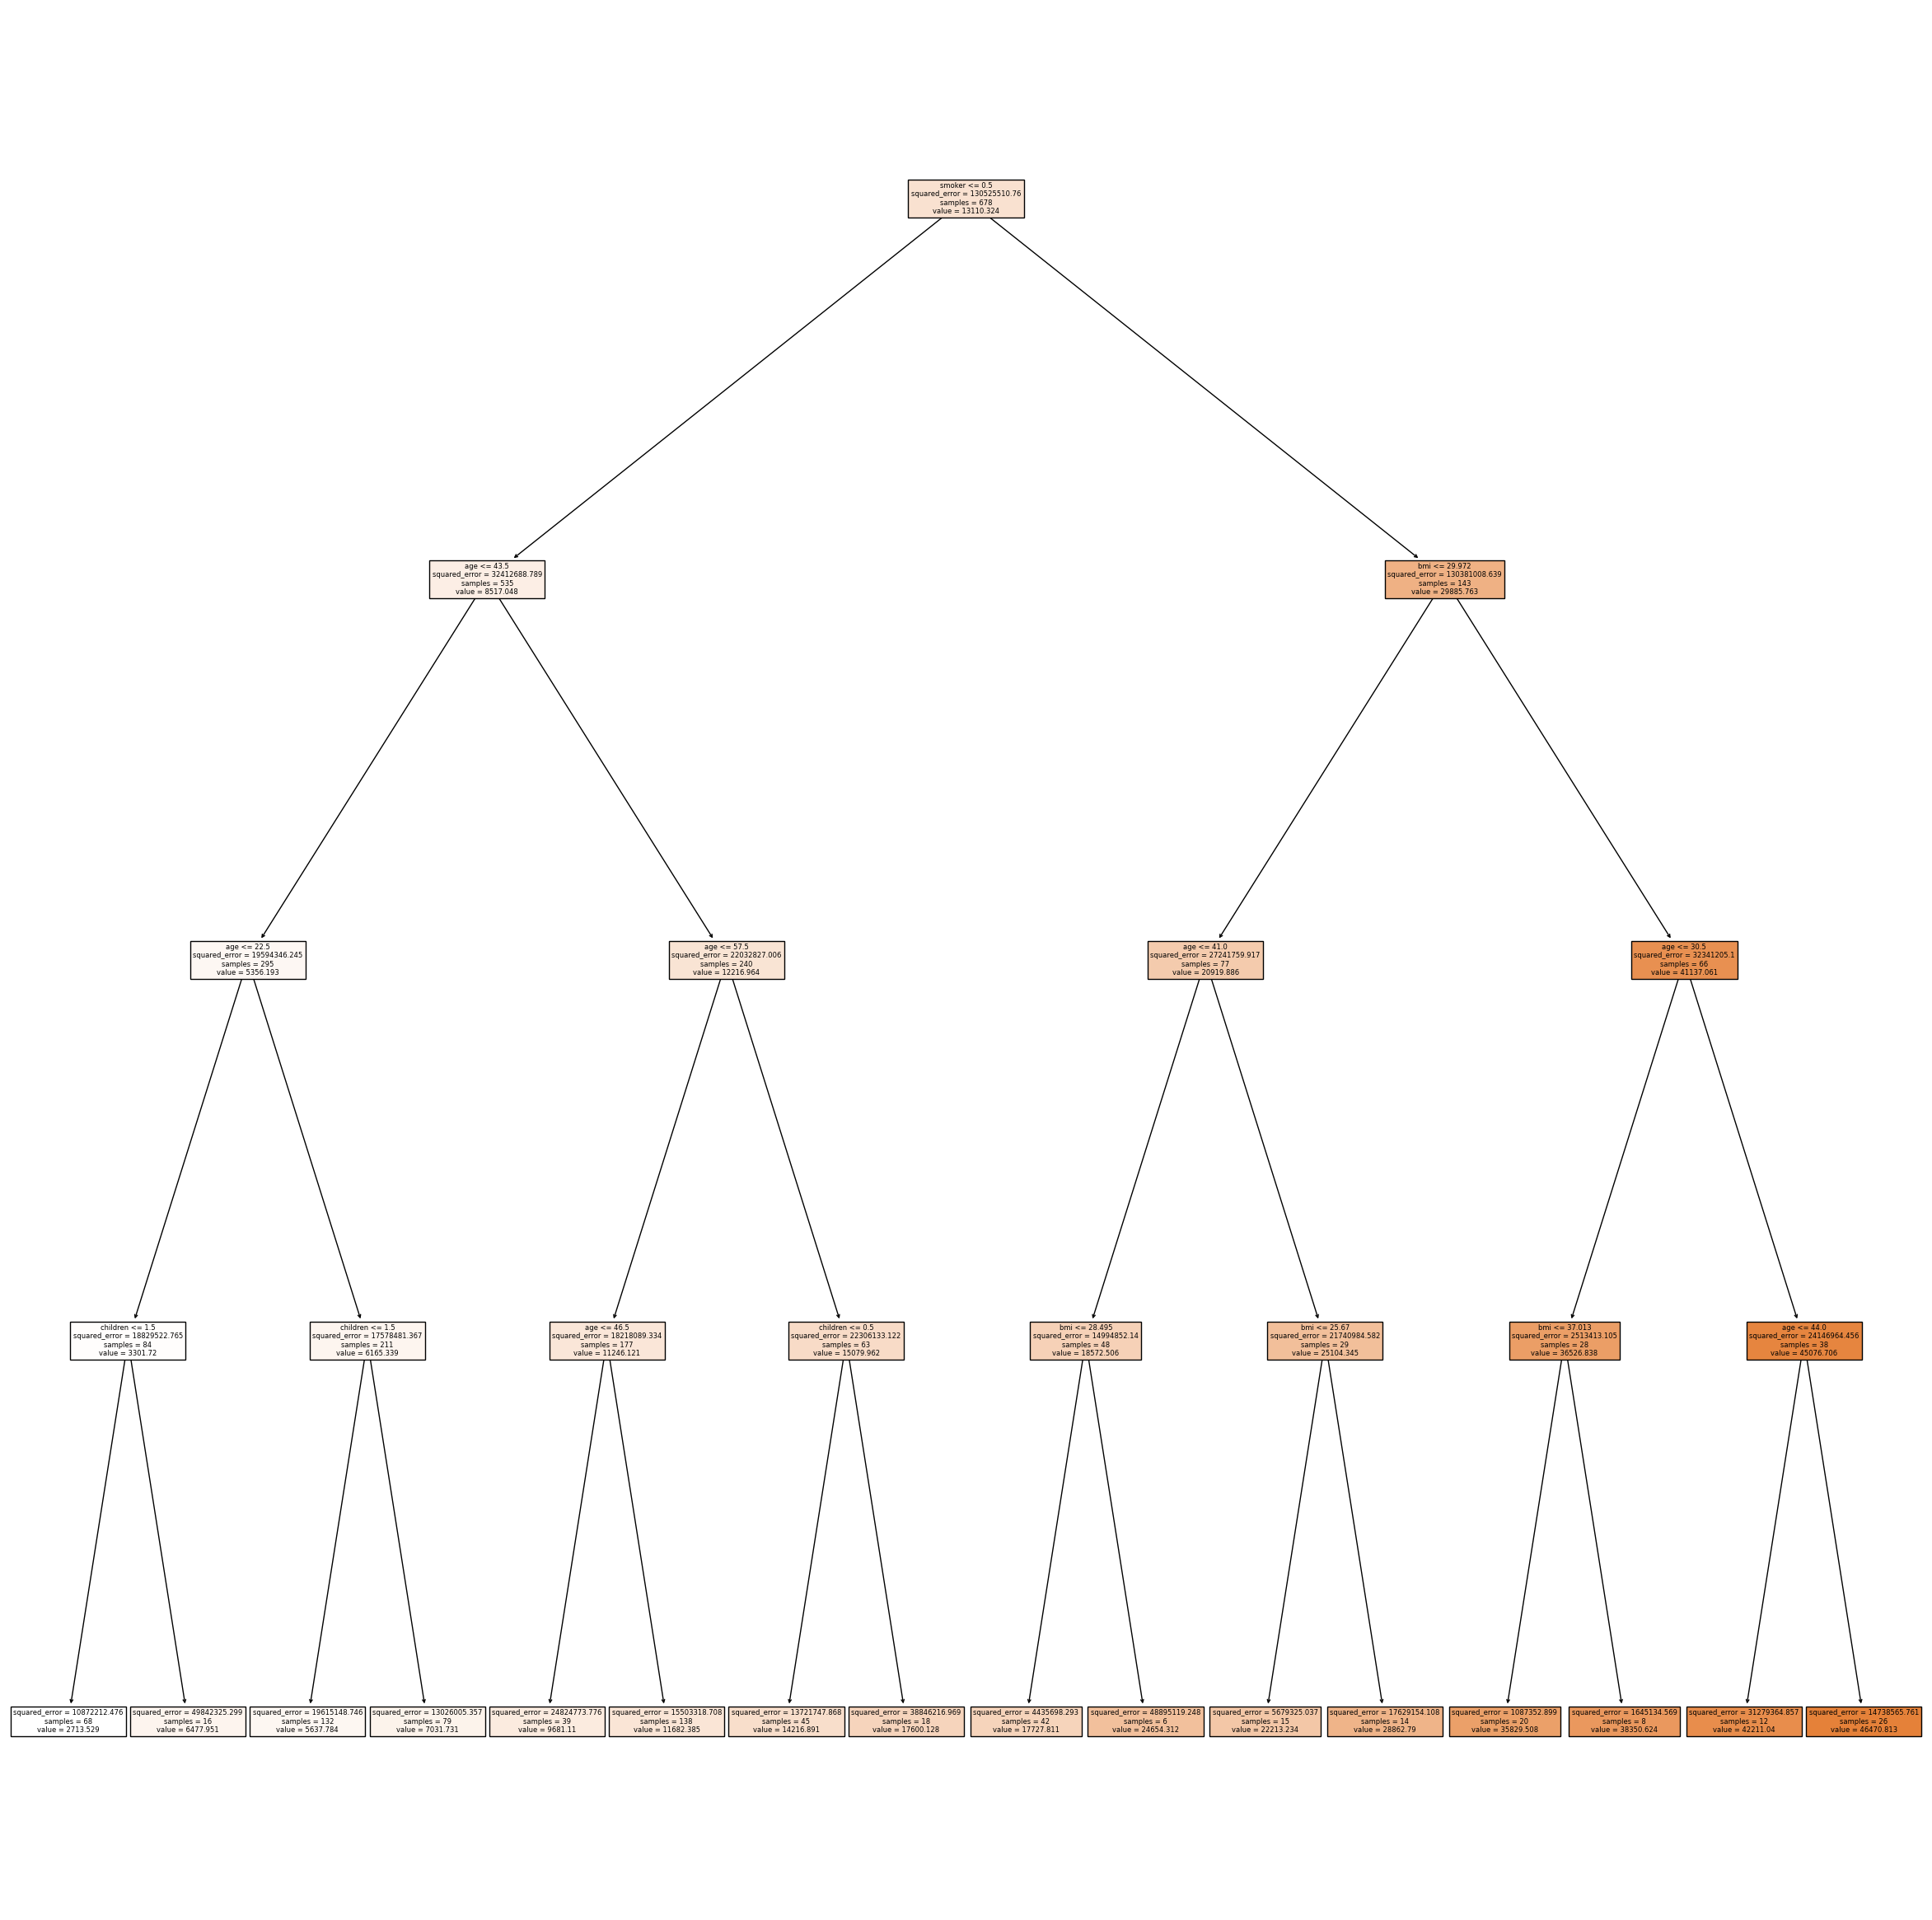

In [44]:
plt.figure(figsize = (30,30))
plot_tree(rf_grid.best_estimator_.estimators_[2],
          feature_names=rf_grid.best_estimator_.feature_names_in_,
          filled=True,)
plt.show()

Zobaczymy jak wygląda wykres Feature Importance

<Axes: title={'center': 'Feature Importance'}>

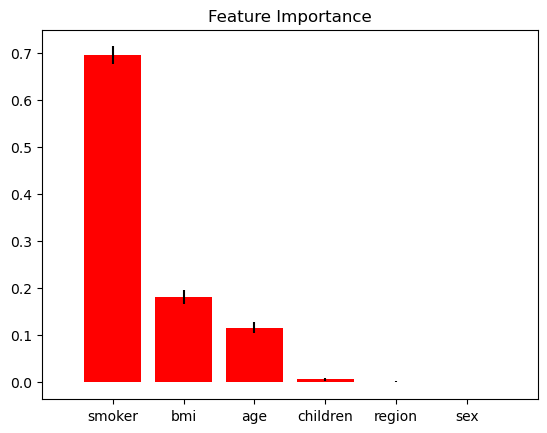

In [45]:
skplt.estimators.plot_feature_importances(rf_grid.best_estimator_, feature_names=insurance_df.drop('charges', axis=1).columns)

Wykonajmy to samo dla XGBRegressor

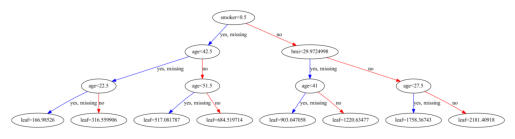

In [46]:
xgb.plot_tree(xgb_reg_grid.best_estimator_, num_trees=0)
plt.show()

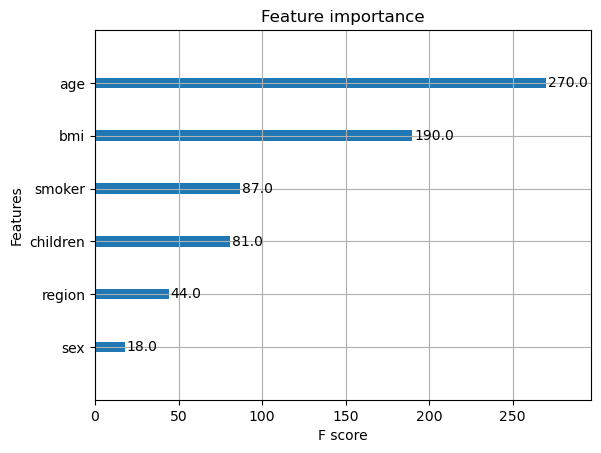

In [47]:
xgb.plot_importance(xgb_reg_grid.best_estimator_)
plt.show()

Przykładowe predykcje dla najlepszego estymatora

In [48]:
rf_grid.best_estimator_.fit(X_train, y_train)
y_test_pred = rf_grid.best_estimator_.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
df.sample(10)

,Actual,Predicted
351,8932.08400,11153.390979
581,1639.56310,2852.408170
113,2404.73380,3063.597726
1073,12096.65120,12972.881286
890,29330.98315,27559.825643
1143,6338.07560,6758.897034
591,8428.06930,10682.590073
115,30259.99556,14073.609132
410,1621.34020,2853.237886
506,2643.26850,4382.111970


## Wnioski:

- Najlepiej zastosowac model RandomForestRegressor
- Biorąc pod uwagę róznice korelacji dla palących i nie palących, dobrze by było posiadac więcej (inne?) zmiennych dla tych grup